# Testing an approach to timing and parse probabilities

For noiseless dynamical systems, $1 /\vert\lambda\vert$, where $\lambda$ is the smallest-magnitude eigenvalue of a stable fixed point, gives the characteristic time scale of that fixed point. Attractors with higher-magnitude $\lambda$s pull the system faster than attractors with smaller $\lambda$s. For SOSP, then, we should expect differences in reading times between two alternative parses if their characteristic time scales are different. With a noisy system, this property should still hold as long as the magnitude of the noise is small enough, e.g., maybe if the eigenvalues of the noise matrix are smaller in magnitude than those of the linearized noiseless dynamics?

A simple approach to relative parse probabilities: After reading a word, the state of an SOSP parser will be somewhere between attractors, likely near a separatrix between two or more attractor basins. The system will then settle toward an attractor until it gets sufficiently close. To estimate analytically which attractors are most likely, we decide in advance which attractors are most relevant, e.g., the nearest $n$ parses. We then estimate the probability of being in each parse by integrating the stationary probability distribution over a small area containing the harmony peak for that parse. The relative probability of each parse is then just this integral divided by the sum of all relevant integrals.

To estimate the overall average reading time, we simply take the weighted average of the characteristic time scales of the relevant attractors weighted by their relative probabilities.

## A simple test system

Here, I'll consider a 1D example to test this approach. The noiseless harmony function is
$$
H(\mathbf{x}) = \sum_{i \in {0, 1}} h_i\phi_i(\mathbf{x}) = h_0\exp\left(-\frac{x^2}{\gamma} \right) + h_1\exp\left(-\frac{(x-1)^2}{\gamma} \right)
$$
The $h_i$ are the local harmony values for each peak (here, $h_0 = 2$ and $h_1 = 1$), and $\gamma = 0.15$ is a parameter that sets the widths of the peaks.

The dynamics of the system is given by the gradient of the harmony function:
$$
\mathbf{\dot{x}} = \nabla H(\mathbf{x}) = -\frac{2 h_0}{\gamma} x \exp\left(-\frac{x^2}{\gamma} \right) - \frac{2 h_1}{\gamma} (x - 1) \exp\left(-\frac{(x-1)^2}{\gamma} \right)
$$

The linearization (which in this case is equivalent to the Hessian matrix of $H$) is tedious to calculate by hand, so I'll let SymPy do it for me below.

With a Gaussian noise term $dW \sim N(0, D)$ added, the final harmony function, which we can use to derive the stationary probability distribution, is:
$$
H(\mathbf{x}) = \sum_{i \in {0, 1}} h_i\phi_i(\mathbf{x}) + \sqrt{2D}dW
$$

This is a Langevin equation for which the associated Fokker-Planck equation is (Gardiner, 1985):
$$
\frac{\partial P(\mathbf{x}, t)}{\partial t} = -\frac{\partial \nabla H}{\partial x} P(\mathbf{x}, t) + \frac{\partial^2 D P(\mathbf{x}, t)}{\partial x^2}
$$

The stationary solution for this Fokker-Planck equation is:
$$
P_s(\mathbf{x}) = \mathcal{N}^{-1} \exp\left(H(\mathbf{x}) / D \right) \propto \exp\left(H\mathbf{x} / D \right)
$$
where $\mathcal{N}$ is a normalization constant that ensures $\int P_x dx = 1$. We can use $\mathcal{N} = \int \exp\left(H(\mathbf{x})/D\right)dx$

***
Now, let's turn to SymPy to start analyzing this system.

In [394]:
from sympy import *
init_printing()  # Makes the outputs look nicer
from IPython.display import display

x, h0, h1, gamma, D = symbols('x h0 h1 gamma D')
h0 = 2.0
h1 = 1.0
D = 1.0
gamma = 0.2

H = h0*exp(-x**2 / gamma) + h1*exp(-(x-1)**2 / gamma)  # defining the harmony function
#print('H =')
#display(H)

dxdt = diff(H, x)  # taking the gradient of H wrt. x
#print('\ndx/dt = ')
#display(dxdt)

Next, we set up the stationary probability distribution and find its normalization:

In [395]:
# The unnormalized stationary probability distribution, with values substituted in for the various parameters
Punnrom = exp(H / D)
# Finding the normalization; note the end points of the integration were chosen basically arbitrarily
normalization = Integral(Punnorm, (x, -2, 3)).evalf()  # Takes < a minute to evaluate the integral
normalization
Ps = (1 / normalization) * Punnorm

In [396]:
# With this harmony function, the fixed points aren't exactly at 0 and 1, though; they get pulled together a 
# bit due to the summing of their Gaussians. So we first find the zeros of dxdt:
x0 = nsolve(dxdt, x, 0)  # using a numeric solver
x1 = nsolve(dxdt, x, 1)
print('Zeros of H(x):\n{}\n{}'.format(*[x0, x1]))

# Finding harmony minimum between x0 and x1
xmid = nsolve(dxdt, x, 0.5)
print('Local harmony minimum: x = {}'.format(xmid))

Zeros of H(x):
0.00347601376330667
0.984510061511192
Local harmony minimum: x = 0.616996743454593


In [397]:
# Now we can calculate the ratio of the probabilities of x0 to x1 (Cho et al., 2018)
#ratio = exp((H.subs(x, x0) - H.subs(x, x1)) / D)
#ratio
ratio = Ps.subs(x, x0) / Ps.subs(x, x1)
ratio

In [398]:
# Now we can calculate the relative probabilities of each attractor:
#Psubs = Punnorm.subs([(gamma, 0.15), (h0, 2), (h1, 1), (D, 0.1)])  # substituting in parameter values
#Ps = normalization**-1 * Punnorm
#display(Ps)
p0 = Psubs.subs(x, x0) / (Psubs.subs(x, x0) + Psubs.subs(x, x1))
#p0 = Punnorm.subs(x, x0) / (Punnorm.subs(x, x0) + Punnorm.subs(x, x1))
#p1 = Punnorm.subs(x, x1) / (Punnorm.subs(x, x0) + Punnorm.subs(x, x1))
#p0 = Ps.subs(x, x0) / (Ps.subs(x, x0) + Ps.subs(x, x1))  # Works, but doesn't accord with the simulations...
p1 = Ps.subs(x, x1) / (Ps.subs(x, x0) + Ps.subs(x, x1))
#print('Relative probabilities:\nx0 = {}\nx1 = {}'.format(*[p0, p1]))

# Trying original integration idea
#px0 = Integral(Ps, (x, x0-0.1, x0+0.1)).evalf()
#px1 = Integral(Ps, (x, x1-0.1, x1+0.1)).evalf()
#print(px0, px1)
#p0 = px0 / (px0 + px1)
#p1 = px1 / (px0 + px1)
print('Relative probabilities:\nx0 = {}\nx1 = {}'.format(*[p0, p1]))

Relative probabilities:
x0 = 0.999954441118269
x1 = 0.0000455588817312858


In [399]:
# From Gardiner (1985, p. 346, eq. 9.1.21)
lin = dxdt.diff(x)  # linearization of the dynamics/second derivative of the harmony function
# this approximates how far off the numerically-found location xmid is from the actual midpoint
# Because it's positive, that means we're starting just to the right of the midpoint
err = 0.001
pan1 = 0.5*(1 - erf(err * sqrt(lin.subs(x, xmid) / 0.1)))
pan0 = 1 - pan1
print('Analytical relative probabilities:\nx0 = {}\nx1 = {}'.format(*[pan0, pan1]))

Analytical relative probabilities:
x0 = 0.505811211310515
x1 = 0.494188788689485


Great! So, this approach predicts that an SOSP parser using this harmony landscape should approach the attractor at x=0 about 73% of the time and x=1 27% of the time, if it starts about halfway between them.

Now, we can look at how fast the system should approach each attractor. To do this, we simply find the lowest-magnitude eigenvalue $\lambda$ of the linearized dynamics at each fixed point. Then, $1/\vert\lambda\vert$ gives the characteristic time scale of that attractor.

In [400]:
char0 = abs(lin.subs(x, x0))
char1 = abs(lin.subs(x, x1))
print('Characteristic time scales:\nx0 = {}\nx1 = {}'.format(*[1/char0, 1/char1]))

Characteristic time scales:
x0 = 0.0516171935881239
x1 = 0.116305826729635


As we can see, the characteristic time scale for the attractor near x = 0 is faster (closer to zero) than that of the attractor near x = 1. Thus, we expect faster processing times when the system "chooses" x0 compared to x1. Now we can test these predictions using simulations of the system. 

(Something to keep an eye on is what $D$, the noise magnitude is doing...)

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

centers = np.array([0, 1])
harmonies = np.array([2., 1])
#gamma = 0.15
ndim = 1
#noisemag = 0.1  # D above
maxsteps = 1000
tau = 0.01
xinit = np.float(xmid)  # starting at the midpoint between the two attractors


# Defining phi function
def phi(x, center, gamma):
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


# A function for updating the state of the system according to the negative
# gradient of the harmony function
def step_dyn(x, centers, harmonies, gamma):
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


# Are we close to an attractor?
def not_close(x, centers, tol):
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros(maxsteps)
nruns = 5000
data = np.zeros((nruns, 2))  # first column for which attr, second for time

for run in range(nruns):
    if run % 500 == 0:
        print('[{}] '.format(run), end='')
    xhist[0] = xinit
    noise = np.random.normal(0, 1, xhist.shape)
    t = 0
    while t < maxsteps-1:
        if not_close(xhist[t], centers, 0.1):
            xhist[t+1] = (xhist[t] + tau*step_dyn(xhist[t], centers, harmonies, gamma)
                      + np.sqrt(2*D*tau)*noise[t])
            t += 1
        else:
            break
    data[run, :] = [np.round(xhist[t]), t]

if nruns == 1:
    plt.plot(xhist)
    plt.show()


[0] [500] [1000] [1500] [2000] [2500] [3000] [3500] [4000] [4500] 

In [402]:
# Now looking at the data
mean0 = np.mean(data[np.where(data[:,0] == 0), 1])
mean1 = np.mean(data[np.where(data[:,0] == 1), 1])
ratio_emp = data[np.where(data[:,0] == 0), 0].shape[1] / data[np.where(data[:,0] == 1), 0].shape[1]
print('\nProportion of x0 runs:\t\t{} (predicted: {})'.format(1-np.mean(data[:, 0]), pan0))
print('Ratio of x0 runs to x1 runs:\t{} (predicted: {})'.format(ratio_emp, ratio))
print('\nMean RT for x0:\t\t\t{}'.format(mean0))
print('Mean RT for x1:\t\t\t{}'.format(mean1))
print('Ratio of x1 to x0 RTs:\t\t{} (predicted: {})'.format(mean1 / mean0, (1/char1) / (1/char0)))



Proportion of x0 runs:		0.44820000000000004 (predicted: 0.505811211310515)
Ratio of x0 runs to x1 runs:	0.8367046708348658 (predicted: 21948.6168913490)

Mean RT for x0:			12.029010989010988
Mean RT for x1:			8.77418168444281
Ratio of x1 to x0 RTs:		0.7294183779912079 (predicted: 2.25323809073562)


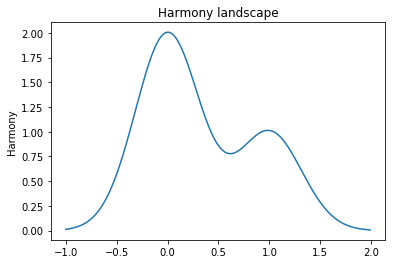

In [403]:
# Looking at the harmony landscape
xrange = np.arange(-1., 2, 0.01)
harmony = np.zeros(xrange.shape)
for i in range(len(xrange)):
    harmony[i] = calc_harmony(xrange[i], centers, harmonies, gamma)
plt.plot(xrange, harmony)
plt.title('Harmony landscape')
plt.ylabel('Harmony')
plt.show()

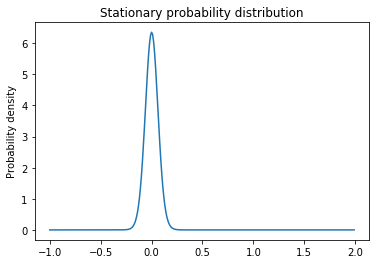

In [404]:
# Now plotting the stationary probability distribution Ps
Psnum = lambdify(x, Ps)
probs = np.zeros(xrange.shape)
for i in range(len(xrange)):
    probs[i] = Psnum(xrange[i])
plt.plot(xrange, probs)
plt.title('Stationary probability distribution')
plt.ylabel('Probability density')
plt.show()

## Discussion
In accordance with the analytical predictions, the system settled slightly more often to the fixed point at x = 0 that to x = 1, and it was also faster in settling to x = 0 than x = 1. The proportions predicted by the Gardiner (1985) equation are particularly promising, although there is still some very naive approximating there on my part. Open issues:
1. The simple approach I proposed in the introduction for calculating relative probabilities seems to be way off.
2. As I mentioned, I simply guessed at a deviation from the actual harmony minimum in the Gardiner calculation. For scaling up, I haven't been able to find anything on splitting probabilities in higher dimensions.
3. It's not clear how to map from characteristic time scales to actual RTs. Using a more sophisticated approach (e.g., mean exit times; Gardiner, Ch. 9.3.2) might give a better approximation, but the math gets hard pretty fast.

**Problem seems to be in how the probability distribution function is being calculated. Check carefully!!**